In [1]:
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/zips/test2017.zip

--2023-12-11 15:45:39--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.136.233, 16.182.39.89, 3.5.20.102, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.136.233|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  21.5MB/s    in 16m 4s  

2023-12-11 16:01:44 (19.1 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2023-12-11 16:01:44--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.125.209, 52.217.236.113, 3.5.9.127, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.125.209|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777

In [2]:
import os
import zipfile
from tqdm import tqdm


# Python function to unzip files
def unzip(zip_file_path, extract_to_dir):

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Get the total number of items in the zip file for tqdm
        total_items = sum(1 for _ in zip_ref.infolist())

        # Set up tqdm to display progress bar
        with tqdm(total=total_items, desc="Unzipping", unit="item") as pbar:
            # Extract each item in the zip file
            for item in zip_ref.infolist():
                zip_ref.extract(item, extract_to_dir)
                pbar.update(1)

# Unzip validation directory
unzip('train2017.zip', 'train2017')
unzip('val2017.zip', 'val2017')
unzip('test2017.zip', 'test2017')


# Consider only first 10000 images from the train, val and test directories
def keep_first_n_files(directory, n):

    # Get the list of files in the directory
    files = os.listdir(directory)

    # Sort the files by name to ensure consistent order
    files.sort()

    # Iterate over the files and remove those beyond the first n
    for file_name in tqdm(files[n:]):
        file_path = os.path.join(directory, file_name)
        os.remove(file_path)


# Example usage:
train_directory_path = '/content/train2017/train2017'
test_directory_path = '/content/test2017/test2017'
images_to_consider = 10000
keep_first_n_files(train_directory_path, images_to_consider)
keep_first_n_files(test_directory_path, images_to_consider)

100%|██████████| 30670/30670 [00:01<00:00, 17614.93it/s]


In [3]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from keras import layers

In [5]:
def convertToGreyScale(color_img_dir, save_grey_img_dir):
    for img_name in os.listdir(color_img_dir)[:10000]:
        # Load the image
        img = cv2.imread(color_img_dir + img_name)
        # Convert input image to grayscale
        grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Save grayscale image
        cv2.imwrite(save_grey_img_dir + img_name, grayscale_img)

convertToGreyScale('/content/train2017/train2017/', '/content/traingrey/')
convertToGreyScale('/content/test2017/test2017/', '/content/testgrey/')

In [6]:
# to get the files in proper order
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

In [7]:
def resizing(images_path, flag=False):
    SIZE = 160
    img_array = []
    files = os.listdir(images_path)
    files = sorted_alphanumeric(files)
    for i in tqdm(files):
        img = cv2.imread(images_path + '/' + i, 1)
        if flag:
            # open cv reads images in BGR format so we have to convert it to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        img_array.append(img_to_array(img))
    return img_array

color_img = resizing('/content/train2017/train2017', flag=True)
gray_img = resizing('/content/traingrey')

100%|██████████| 10000/10000 [01:02<00:00, 160.35it/s]


NotADirectoryError: ignored

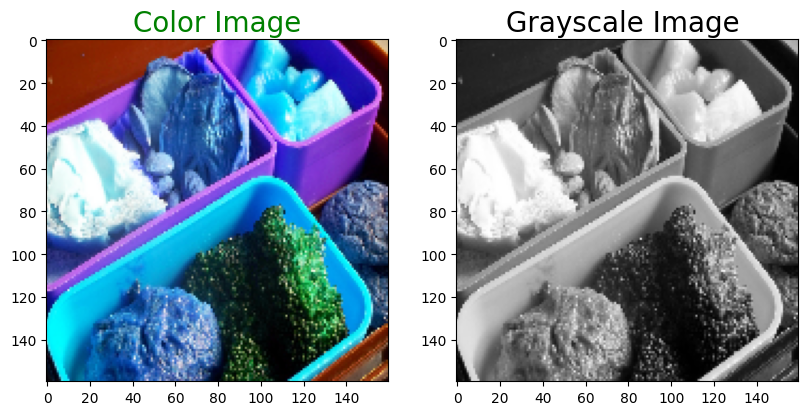

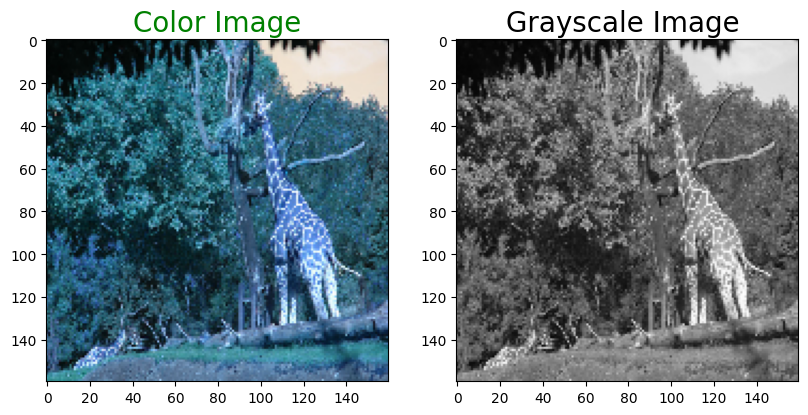

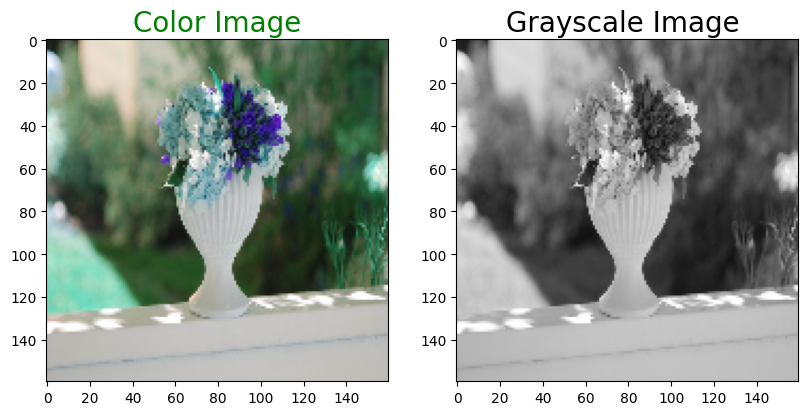

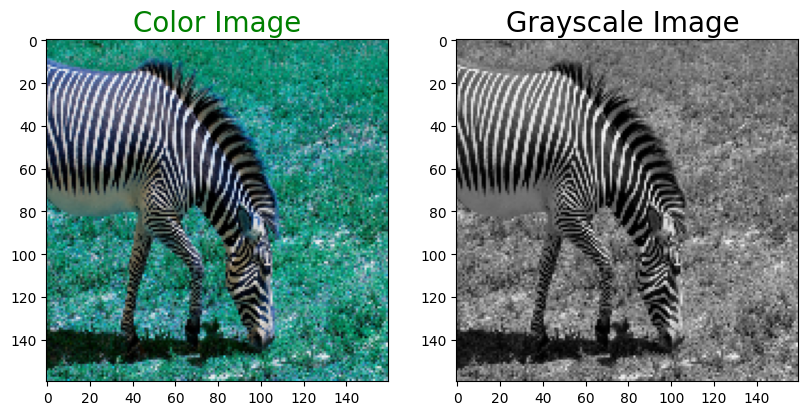

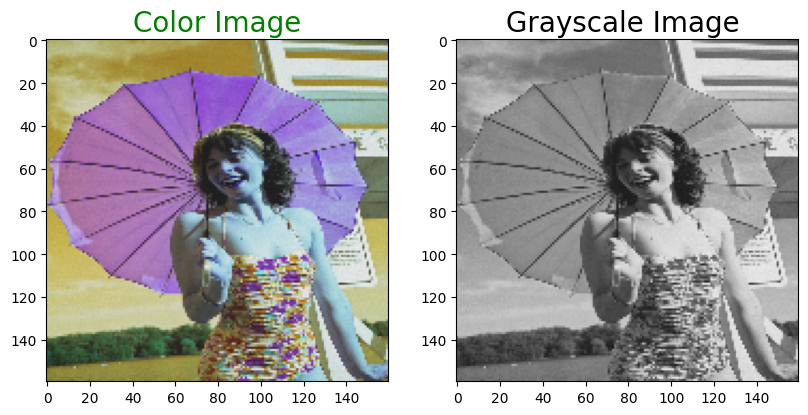

In [18]:
# defining function to plot images pair
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.show()

for i in range(5):
     plot_images(color_img[i], gray_img[i])

In [ ]:
SIZE = 160

train_gray_image = gray_img[:9000]
train_color_image = color_img[:9000]

test_gray_image = gray_img[9000:]
test_color_image = color_img[9000:]
# reshaping
train_g = np.reshape(train_gray_image, (len(train_gray_image), SIZE, SIZE, 3))
train_c = np.reshape(train_color_image, (len(train_color_image), SIZE, SIZE, 3))
print('Train color image shape:', train_c.shape)

test_gray_image = np.reshape(test_gray_image,(len(test_gray_image), SIZE, SIZE, 3))
test_color_image = np.reshape(test_color_image, (len(test_color_image), SIZE, SIZE, 3))
print('Test color image shape', test_color_image.shape)

In [ ]:
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample


def model():
    inputs = layers.Input(shape= [160,160,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)

    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

model = model()
model.summary()

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_error', metrics=['acc'])
model.fit(train_g, train_c, epochs=50, batch_size=50, verbose=0)

In [ ]:
# Save the model
model.save(filepath='model_cv_cnn.h5')

In [ ]:
model.evaluate(test_gray_image, test_color_image)

In [ ]:
# defining function to plot images pair
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
    plt.show()

for i in range(50,58):
    predicted = np.clip(model.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_color_image[i], test_gray_image[i], predicted)